In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [2]:
df = pd.read_csv("../data/creditcard.csv")

y_class = df["Class"]

df = df.drop(columns= ["Class"])

# 02-exploratory_prep

## Preprocessing pipeline 

### Creare uno standard scaler


In [3]:
X = df.values
y = y_class.values
X, y = shuffle(X, y, random_state=42)
X, y

(array([[ 4.15050000e+04, -1.65265066e+01,  8.58497180e+00, ...,
         -2.01857525e+00, -1.04280417e+00,  3.64190000e+02],
        [ 4.42610000e+04,  3.39812064e-01, -2.74374524e+00, ...,
          4.09958027e-02,  1.02037825e-01,  5.20120000e+02],
        [ 3.54840000e+04,  1.39959027e+00, -5.90701288e-01, ...,
          1.14086454e-02,  4.63414166e-03,  3.10000000e+01],
        ...,
        [ 7.97950000e+04, -1.46608925e-01,  9.92946123e-01, ...,
         -1.21139194e-01, -1.96195328e-01,  3.94000000e+00],
        [ 8.79310000e+04, -2.94863809e+00,  2.35484929e+00, ...,
          4.96912107e-01,  3.35821632e-01,  1.00000000e+00],
        [ 7.63810000e+04,  1.23317435e+00, -7.84850501e-01, ...,
          1.21657270e-03,  3.85878912e-02,  1.13000000e+02]]),
 array([1, 0, 0, ..., 0, 0, 0]))

In [4]:
logit = Pipeline([("scat_standard_scaling", StandardScaler()), ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators=50)))])
logit

Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50)))])

In [5]:
logit.fit(X, y)

Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50)))])

In [6]:
logit.steps[0][1].mean_

array([ 9.48138596e+04,  1.15341619e-15,  3.94713176e-16, -1.41452230e-15,
        2.06964615e-15,  1.00043371e-15,  1.53743593e-15, -6.25289293e-16,
        1.08507600e-16, -2.39806177e-15,  2.25190186e-15,  1.64716171e-15,
       -1.24674475e-15,  8.30348059e-16,  1.21338625e-15,  4.88610242e-15,
        1.43702364e-15, -3.75166612e-16,  9.65940458e-16,  1.04286478e-15,
        6.40621337e-16,  1.46629319e-16, -3.45314729e-16,  2.67960047e-16,
        4.48912641e-15,  5.43932371e-16,  1.68924000e-15, -3.55198612e-16,
       -1.22844786e-16,  8.83496193e+01])

In [14]:
Y = logit.transform(X)
Y.shape

(284807, 9)

In [8]:
np.mean(Y, axis=0)

array([ 1.56674814e-17, -4.04161145e-18, -4.98964376e-18,  6.79090516e-17,
        6.38674402e-18,  7.55931030e-18,  1.77631318e-17, -1.32225560e-18,
        1.60167565e-17])

In [9]:
np.std(Y, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Multi dimensional exploration

In [10]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, perplexity=10, learning_rate=20)

pca_search = PCA(random_state=42)

In [11]:
%%time
Y_tsne = tsne.fit_transform(X[:1000])

CPU times: user 21.2 s, sys: 2.04 s, total: 23.2 s
Wall time: 3.45 s


In [12]:
Y_tsne.shape

(1000, 2)

<AxesSubplot:>

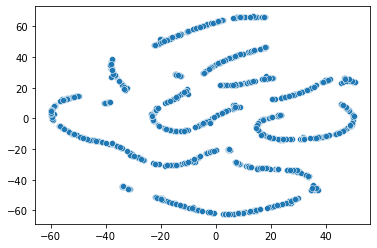

In [13]:
sns.scatterplot(x=Y_tsne[:,0], y=Y_tsne[:,1])